# Ground water model 
### by Adrian

- Sheet 2 Question 2:
    - 1.) Plotting $R(t)$, $h_m(y,t)$, $h_{cm}(t)$, and L2-error convergence for steady state solution
    - 2.) Raining 1s, 2s, 4s, 9s in every 10 second interval + interpretation
- Sheet 2 Question 4:
    - 3.) CG1 and CG2

## 1.) Plotting R(t), h_m(y,t), h_cm(t) and L2 convergence to steady state! (CG3)

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


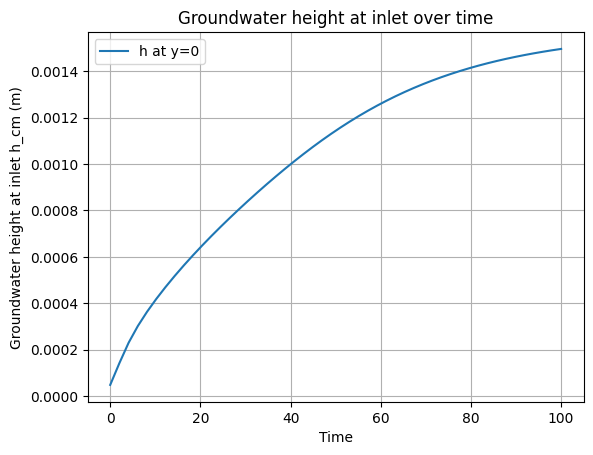

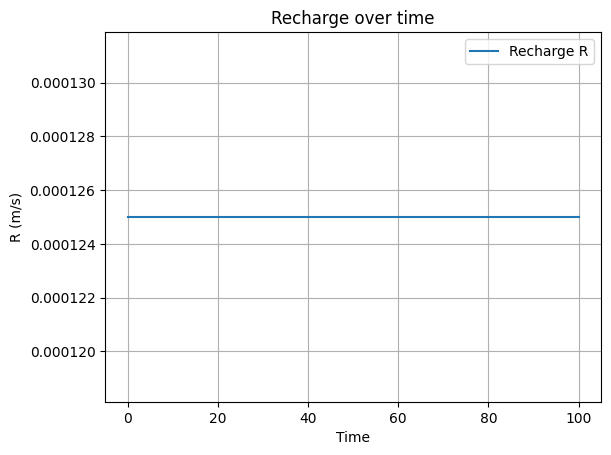

------ h_m -----------
w₂₇
[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7d3ea56ec950>, FiniteElement('Lagrange', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 4)), 25), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7d3ea56ec950>, FiniteElement('Lagrange', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 4)), 27), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7d3ea56ec950>, FiniteElement('Lagrange', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 4)), 29), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7d3ea56ec950>, FiniteElement('Lagrange', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 4)), 31), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object a

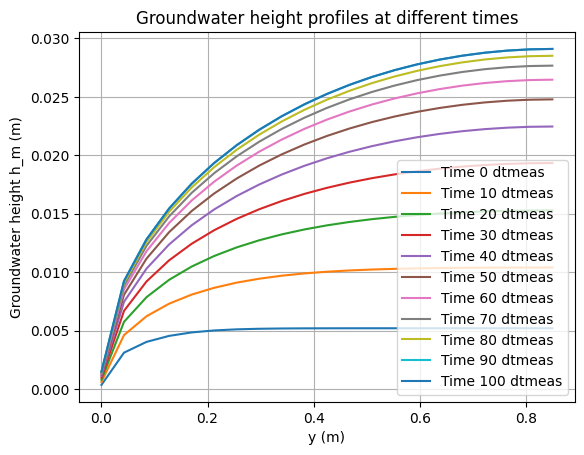

L2 error: 0.004061202927811706 between 0.0 second solution and 10.0 second solution!
L2 error: 0.003489977929748617 between 10.0 second solution and 20.0 second solution!
L2 error: 0.002857961783619626 between 20.0 second solution and 30.0 second solution!
L2 error: 0.002234134793173171 between 30.0 second solution and 40.0 second solution!
L2 error: 0.0016798228968792905 between 40.0 second solution and 50.0 second solution!
L2 error: 0.0012266866613428395 between 50.0 second solution and 60.0 second solution!
L2 error: 0.0008767499842741544 between 60.0 second solution and 70.0 second solution!
L2 error: 0.0006171234457854333 between 70.0 second solution and 80.0 second solution!
L2 error: 0.00042980596379295496 between 80.0 second solution and 90.0 second solution!
L2 error: 7.385913040346258e-08 between 90.0 second solution and 100.0 second solution!


In [ ]:
from firedrake import *
# 
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 50
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 3 # OB2025
V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
theta = 0.5

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
nncase = 1

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

phi = TestFunction(V)

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

if nncase == 0:
   # Provide intial guess to non linear solve
   h = Function(V)
   h.assign(h_prev)
   F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
   bc1 = DirichletBC(V, 0.07, 1)
   h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)

elif nncase == 1:
   if theta == 0.0: # Matches (31)
     h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
     aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
     L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R) ) *dx 
     L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
     explicit_problem = LinearVariationalProblem(aa, L, out)
     explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij', 
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
   elif theta > 0.0: # Matches (30) when theta=1/2
     h = Function(V)
     h.assign(h_prev)
     F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
     # Add boundary contributions at y = 0: 
     F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
     h_problem = NonlinearVariationalProblem( F+F2 , h )
     h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})


h_cm = []
h_m = []
tmeas_10x = 10.0 
R_list = []
# Time loop
while (t < end + Dt):
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        h_m.append(h_prev.copy(deepcopy=True))
        tmeas_10x = tmeas_10x + 10.0
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.show()

# Plot h_m vs y at different times
print("------ h_m -----------")
print(h_m[1])
print(h_m)
y_values = np.linspace(0, Ly, m+1)
num_plots = len(h_m)
print("Number of plots: ", num_plots)
plt.figure()
for j in range(num_plots):
    values = [float(h_m[j].at(i*dy)) for i in range(m+1)]
    print(values)
    plt.plot(y_values, values, label=f'Time {j*10} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.show()

for i in range(num_plots - 1):
    L2 = sqrt(assemble(dot(h_m[i] - h_m[i+1], h_m[i] - h_m[i+1]) * dx))
    print("L2 error: " + str(L2) +" between " + str(i*10.0) + " second solution and " + str((i+1)*10.0) + " second solution!")

Clearly, L2 error of $h_m$ between subsequent times decreases suggesting that $h_m$ converges to the steady state solution.

## 2.) Raining 1s, 2s, 4s, 9s in every 10 second interval (CG3)

### a) Raining for 1 seconds in every 10s 

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


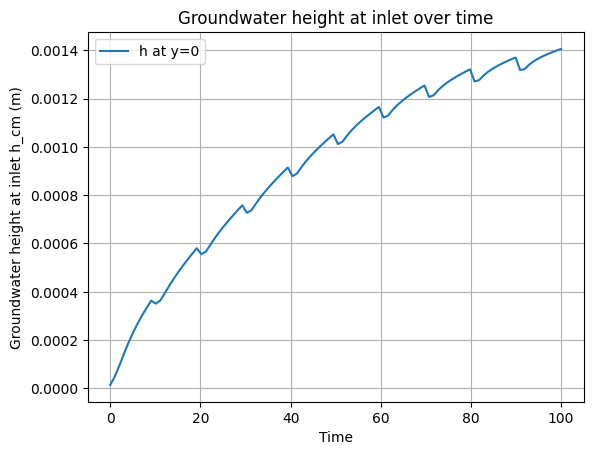

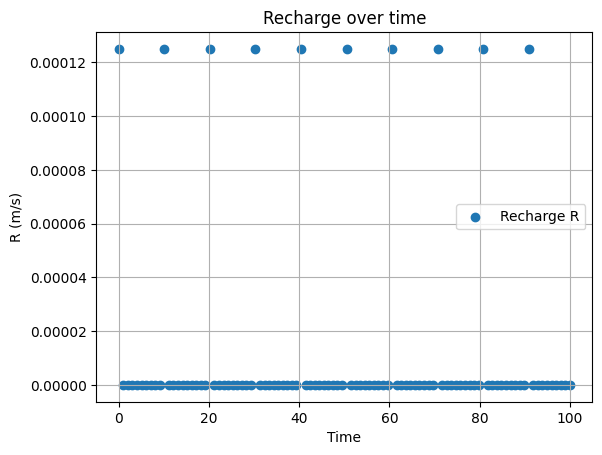

Number of plots:  59


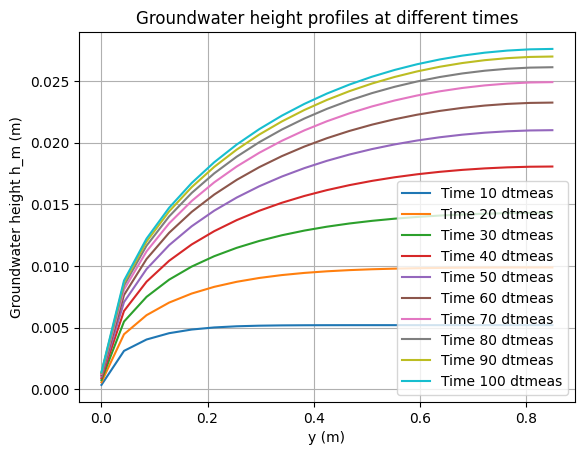

In [15]:
# ### a) Raining for 1 seconds in every 10s
rain_switch = 1

from firedrake import *
# 
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 100
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 3 # OB2025
V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)
phi = TestFunction(V)
h = Function(V)


h_cm.clear()
h_m = {}
tmeas_10x = 10.0 
R_list = []
is_raining = True
is_raining_prev = False
t_rain_end = rain_switch
# Time loop
while (t < end + Dt + 0.1):

    # Redefine the problem if raining status has changed
    if is_raining_prev != is_raining:
        h.assign(h_prev)
        F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
        # Add boundary contributions at y = 0: 
        F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
        h_problem = NonlinearVariationalProblem( F+F2 , h )
        h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
        is_raining_prev = is_raining


    if is_raining:
        R=0.000125
    else:
        R=0.0
    if int(t) >= t_rain_end :
        is_raining = False
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        tmeas_10x = tmeas_10x + 10.0
        # Every 10 seconds start raining for rain_switch seconds
        is_raining = True
        t_rain_end = int(t) + rain_switch
        to_save = [float(h_prev.at(i*dy)) for i in range(m+1)]
        h_m[t] = to_save
        if int(t) >= int(end):
             break
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.scatter(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.show()

# Plot h_m vs y at different times
y_values = np.linspace(0, Ly, m+1)
times = list(h_m.keys())
print("Number of plots: ", num_plots)
plt.figure()
for time in times:
    plt.plot(y_values, h_m[time], label=f'Time {int(time)} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.show()

### b) Raining for 2 seconds in every 10s 

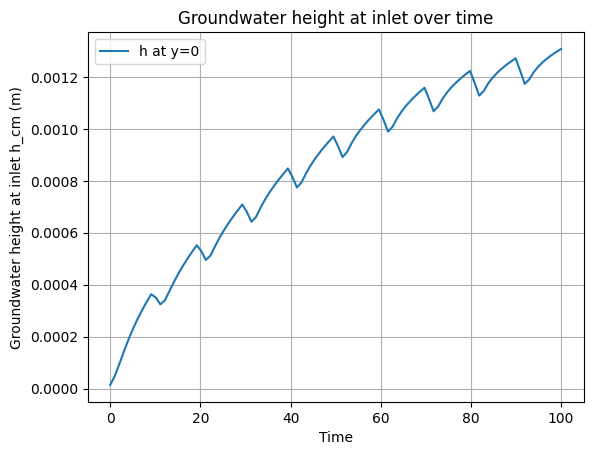

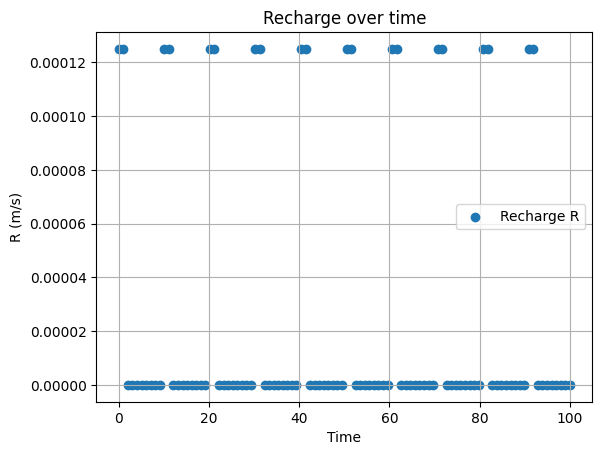

Number of plots:  59


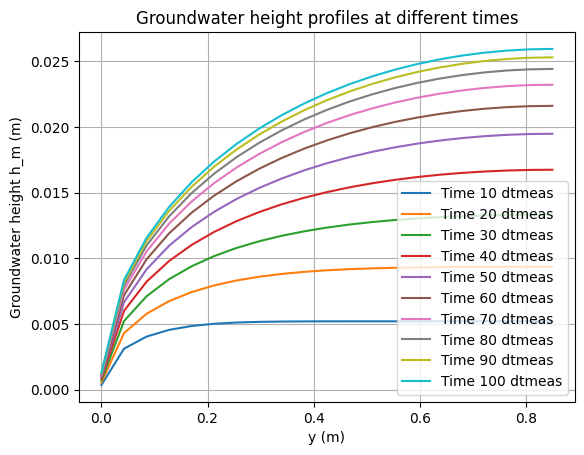

In [16]:
# ### a) Raining for 2 seconds in every 10s
rain_switch = 2

from firedrake import *
# 
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 100
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 3 # OB2025
V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)
phi = TestFunction(V)
h = Function(V)


h_cm.clear()
h_m = {}
tmeas_10x = 10.0 
R_list = []
is_raining = True
is_raining_prev = False
t_rain_end = rain_switch
# Time loop
while (t < end + Dt + 0.1):

    # Redefine the problem if raining status has changed
    if is_raining_prev != is_raining:
        h.assign(h_prev)
        F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
        # Add boundary contributions at y = 0: 
        F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
        h_problem = NonlinearVariationalProblem( F+F2 , h )
        h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
        is_raining_prev = is_raining


    if is_raining:
        R=0.000125
    else:
        R=0.0
    if int(t) >= t_rain_end :
        is_raining = False
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        tmeas_10x = tmeas_10x + 10.0
        # Every 10 seconds start raining for rain_switch seconds
        is_raining = True
        t_rain_end = int(t) + rain_switch
        to_save = [float(h_prev.at(i*dy)) for i in range(m+1)]
        h_m[t] = to_save
        if int(t) >= int(end):
             break
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.scatter(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.show()

# Plot h_m vs y at different times
y_values = np.linspace(0, Ly, m+1)
times = list(h_m.keys())
print("Number of plots: ", num_plots)
plt.figure()
for time in times:
    plt.plot(y_values, h_m[time], label=f'Time {int(time)} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.show()

### c) Rainning 4s in every 10s

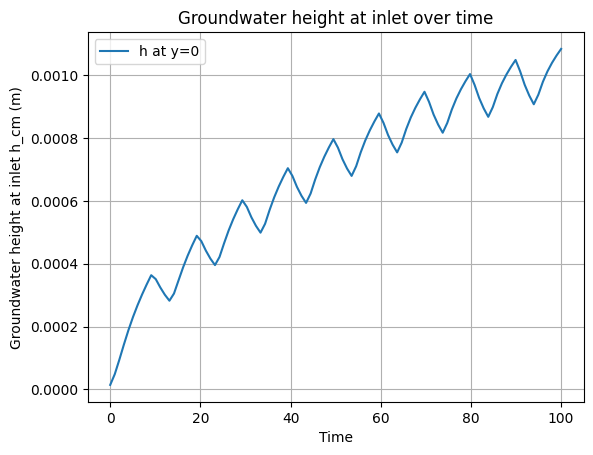

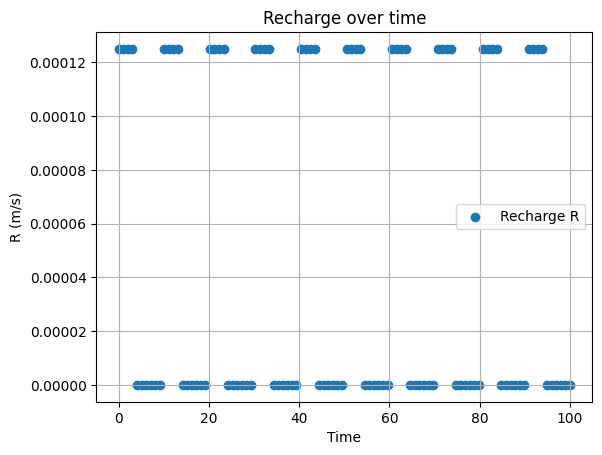

Number of plots:  59


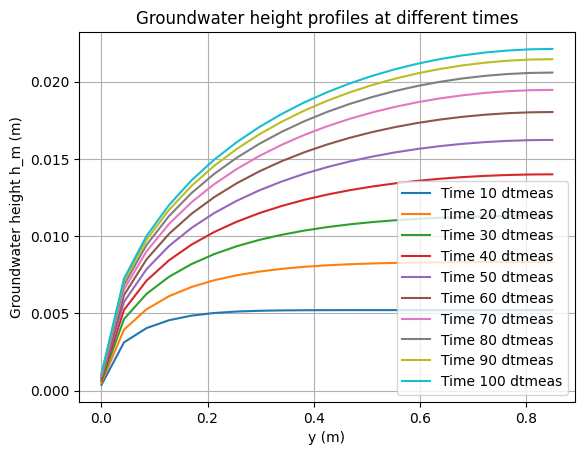

In [17]:
# ### a) Raining for 2 seconds in every 10s
rain_switch = 4

from firedrake import *
# 
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 100
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 3 # OB2025
V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)
phi = TestFunction(V)
h = Function(V)


h_cm.clear()
h_m = {}
tmeas_10x = 10.0 
R_list = []
is_raining = True
is_raining_prev = False
t_rain_end = rain_switch
# Time loop
while (t < end + Dt + 0.1):

    # Redefine the problem if raining status has changed
    if is_raining_prev != is_raining:
        h.assign(h_prev)
        F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
        # Add boundary contributions at y = 0: 
        F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
        h_problem = NonlinearVariationalProblem( F+F2 , h )
        h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
        is_raining_prev = is_raining


    if is_raining:
        R=0.000125
    else:
        R=0.0
    if int(t) >= t_rain_end :
        is_raining = False
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        tmeas_10x = tmeas_10x + 10.0
        # Every 10 seconds start raining for rain_switch seconds
        is_raining = True
        t_rain_end = int(t) + rain_switch
        to_save = [float(h_prev.at(i*dy)) for i in range(m+1)]
        h_m[t] = to_save
        if int(t) >= int(end):
             break
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.scatter(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.show()

# Plot h_m vs y at different times
y_values = np.linspace(0, Ly, m+1)
times = list(h_m.keys())
print("Number of plots: ", num_plots)
plt.figure()
for time in times:
    plt.plot(y_values, h_m[time], label=f'Time {int(time)} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.show()

### d) Rainning every 9s in every 10s

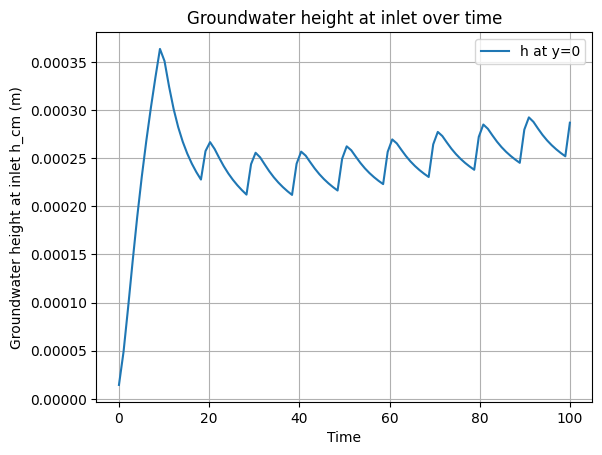

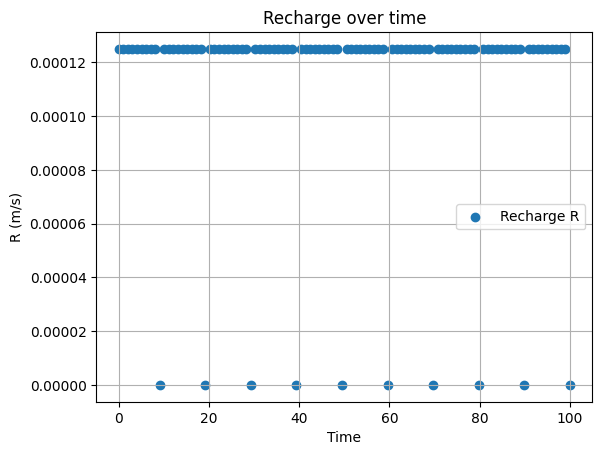

Number of plots:  59


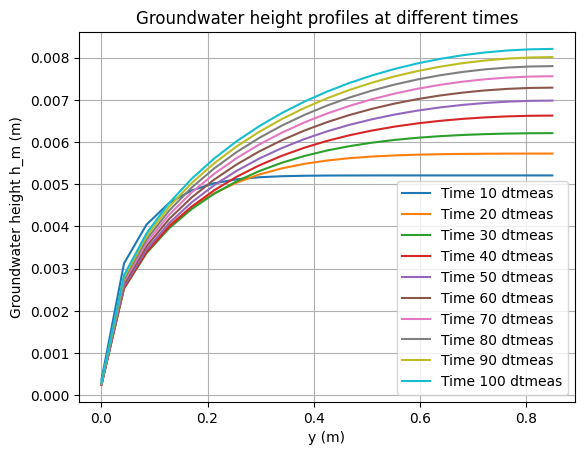

In [18]:
# ### a) Raining for 2 seconds in every 10s
rain_switch = 9

from firedrake import *
# 
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 100
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 3 # OB2025
V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)
phi = TestFunction(V)
h = Function(V)


h_cm.clear()
h_m = {}
tmeas_10x = 10.0 
R_list = []
is_raining = True
is_raining_prev = False
t_rain_end = rain_switch
# Time loop
while (t < end + Dt + 0.1):

    # Redefine the problem if raining status has changed
    if is_raining_prev != is_raining:
        h.assign(h_prev)
        F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
        # Add boundary contributions at y = 0: 
        F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
        h_problem = NonlinearVariationalProblem( F+F2 , h )
        h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
        is_raining_prev = is_raining


    if is_raining:
        R=0.000125
    else:
        R=0.0
    if int(t) >= t_rain_end :
        is_raining = False
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        tmeas_10x = tmeas_10x + 10.0
        # Every 10 seconds start raining for rain_switch seconds
        is_raining = True
        t_rain_end = int(t) + rain_switch
        to_save = [float(h_prev.at(i*dy)) for i in range(m+1)]
        h_m[t] = to_save
        if int(t) >= int(end):
             break
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.scatter(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.show()

# Plot h_m vs y at different times
y_values = np.linspace(0, Ly, m+1)
times = list(h_m.keys())
print("Number of plots: ", num_plots)
plt.figure()
for time in times:
    plt.plot(y_values, h_m[time], label=f'Time {int(time)} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.show()

### e) Commentary

One of the key observations is that as the number of seconds of raining increases, the maximum ground water height $h_m(y,100)$ is decresing.

This is because by setting $R=0$ we effectivelly reduces outflow of the model,
$$
\partial_t (w_v h_m) = \alpha g \partial_y (w_v h_m \partial_y (h_m)) + \frac{w_v R}{m_{por}\sigma_e}
$$
by turning the term containing $R$ off. 

## 3.) CG1 and CG2

Change the order of basis functions used in the subspace V of the Hilbert space containing full solution. So far order of 3 was used in part 1.). Now use order 1, 2!

### a) CG1

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


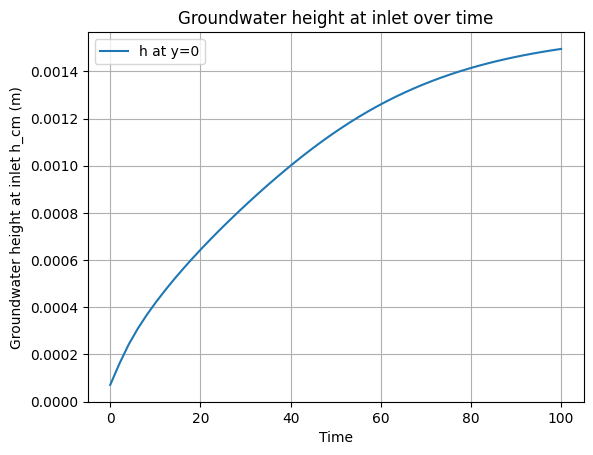

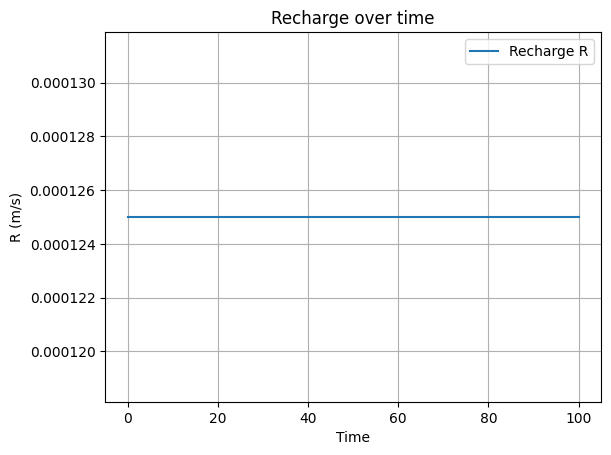

------ h_m -----------
w₂₈₉₁₉₉
[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef455cd0>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144582)), 289197), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef455cd0>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144582)), 289199), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef455cd0>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144582)), 289201), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef455cd0>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144582)), 289203), Coefficient(WithGeometry(FunctionSpa

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


[0.0006098560011123761, 0.004635833097725625, 0.006249114880503549, 0.007321937789371812, 0.008098533006837562, 0.008679864765369085, 0.009121191851076812, 0.00945761158387368, 0.009713566984834597, 0.009907131065565148, 0.010052190431547063, 0.010159662240946164, 0.010238225131222986, 0.01029479140813551, 0.010334836249412848, 0.010362645077651368, 0.010381511121298688, 0.010393898713799664, 0.01040157844373663, 0.010405735120544359, 0.010407047128770558]
[0.0008073102727896601, 0.005765312270116229, 0.00787830676891359, 0.009358260614846447, 0.010492446087357004, 0.01139704227927384, 0.012134034970210863, 0.012741731657103251, 0.01324611366765084, 0.013665967432583588, 0.01401551469639496, 0.014305884130849374, 0.014545988524040416, 0.014743072431101381, 0.014903065722234852, 0.015030817163121647, 0.015130250941580327, 0.015204472148880937, 0.015255837555050068, 0.015286002183943085, 0.015295948464825323]
[0.000980951923318807, 0.006702631508321585, 0.009219183692676668, 0.0110238836

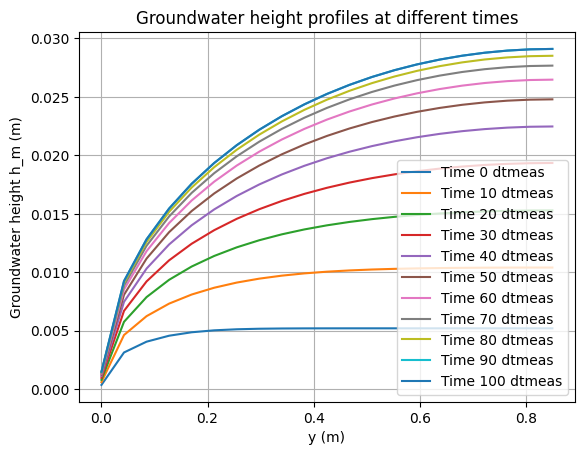

L2 error: 0.004058820642931338 between 0.0 second solution and 10.0 second solution!
L2 error: 0.0034881260067115357 between 10.0 second solution and 20.0 second solution!
L2 error: 0.002856031655864476 between 20.0 second solution and 30.0 second solution!
L2 error: 0.0022320978548942597 between 30.0 second solution and 40.0 second solution!
L2 error: 0.0016778512009549282 between 40.0 second solution and 50.0 second solution!
L2 error: 0.0012249295731775712 between 50.0 second solution and 60.0 second solution!
L2 error: 0.0008752756071312553 between 60.0 second solution and 70.0 second solution!
L2 error: 0.0006159373818375084 between 70.0 second solution and 80.0 second solution!
L2 error: 0.0004288800458549068 between 80.0 second solution and 90.0 second solution!
L2 error: 7.369109994432002e-08 between 90.0 second solution and 100.0 second solution!


In [2]:
nCG = 1 # OB2025

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 50
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3

V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
theta = 0.5

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
nncase = 1

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

phi = TestFunction(V)

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

if nncase == 0:
   # Provide intial guess to non linear solve
   h = Function(V)
   h.assign(h_prev)
   F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
   bc1 = DirichletBC(V, 0.07, 1)
   h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)

elif nncase == 1:
   if theta == 0.0: # Matches (31)
     h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
     aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
     L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R) ) *dx 
     L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
     explicit_problem = LinearVariationalProblem(aa, L, out)
     explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij', 
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
   elif theta > 0.0: # Matches (30) when theta=1/2
     h = Function(V)
     h.assign(h_prev)
     F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
     # Add boundary contributions at y = 0: 
     F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
     h_problem = NonlinearVariationalProblem( F+F2 , h )
     h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})


h_cm = []
h_m = []
tmeas_10x = 10.0 
R_list = []
# Time loop
while (t < end + Dt):
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        h_m.append(h_prev.copy(deepcopy=True))
        tmeas_10x = tmeas_10x + 10.0
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.savefig('./Results/groundwater_height_inlet.png')
plt.show()

plt.figure()
plt.plot(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.savefig('./Results/recharge_over_time.png')
plt.show()

# Plot h_m vs y at different times
print("------ h_m -----------")
print(h_m[1])
print(h_m)
y_values = np.linspace(0, Ly, m+1)
num_plots = len(h_m)
print("Number of plots: ", num_plots)
plt.figure()
for j in range(num_plots):
    values = [float(h_m[j].at(i*dy)) for i in range(m+1)]
    print(values)
    plt.plot(y_values, values, label=f'Time {j*10} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.savefig('./Results/groundwater_height_profiles.png')
plt.show()

for i in range(num_plots - 1):
    L2 = sqrt(assemble(dot(h_m[i] - h_m[i+1], h_m[i] - h_m[i+1]) * dx))
    print("L2 error: " + str(L2) +" between " + str(i*10.0) + " second solution and " + str((i+1)*10.0) + " second solution!")

### b) CG2

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


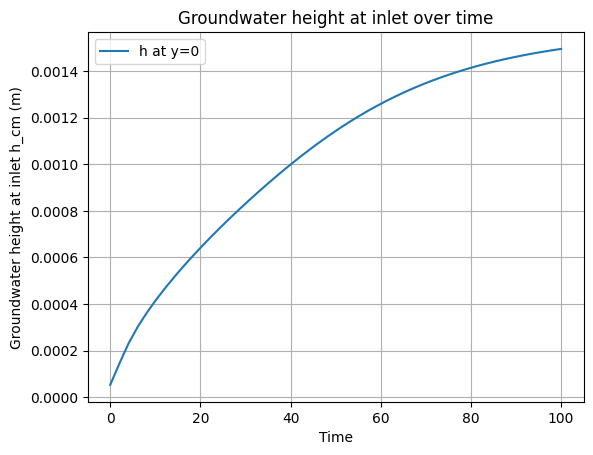

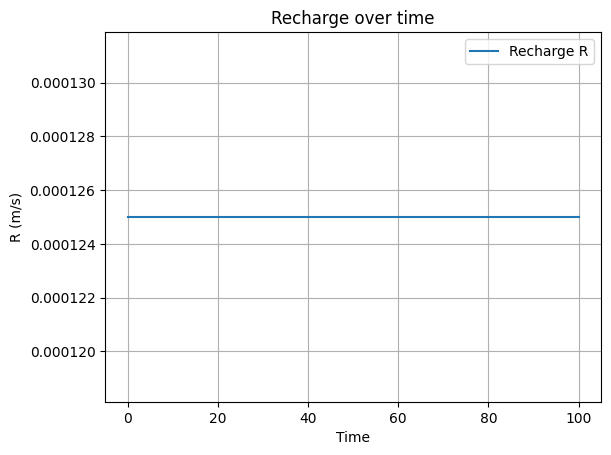

------ h_m -----------
w₂₈₉₃₀₅
[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef670200>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144613)), 289303), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef670200>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144613)), 289305), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef670200>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144613)), 289307), Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7521ef670200>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 144613)), 289309), Coefficient(WithGeometry(FunctionSpa

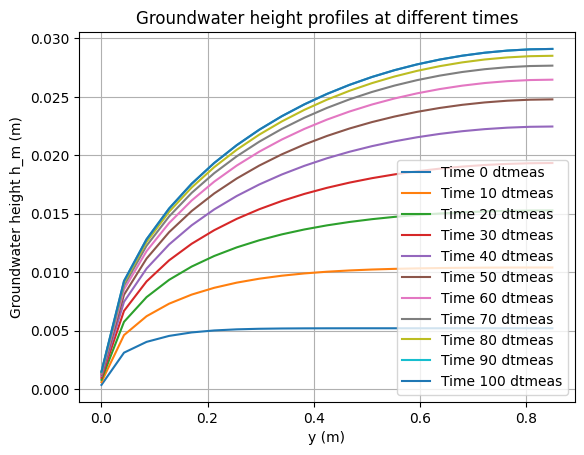

L2 error: 0.004061210761887584 between 0.0 second solution and 10.0 second solution!
L2 error: 0.0034899834514648008 between 10.0 second solution and 20.0 second solution!
L2 error: 0.002857969626415525 between 20.0 second solution and 30.0 second solution!
L2 error: 0.0022341449588692635 between 30.0 second solution and 40.0 second solution!
L2 error: 0.0016798341471758787 between 40.0 second solution and 50.0 second solution!
L2 error: 0.0012266976295798732 between 50.0 second solution and 60.0 second solution!
L2 error: 0.0008767597586617962 between 60.0 second solution and 70.0 second solution!
L2 error: 0.0006171316410243058 between 70.0 second solution and 80.0 second solution!
L2 error: 0.00042981255339296634 between 80.0 second solution and 90.0 second solution!
L2 error: 7.386034123088533e-08 between 90.0 second solution and 100.0 second solution!


In [3]:
nCG = 2 # OB2025

m  = 20
Ly = 0.85
dy = Ly/m
mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh) # OB2025 

# Time definitions
t   = 0.0
end = 100.0
Ntm = 50
dtmeas = end/Ntm
tmeas = dtmeas

# 
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3

V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
CFL = 2.3
Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
theta = 0.5

# Define Groundwater constants
mpor  = 0.3
sigma = 0.8
Lc    = 0.05
kperm = 1e-8
w     = 0.1
R     = 0.000125
nu    = 1.0e-6
g     = 9.81
alpha = kperm/( nu * mpor * sigma )
gam   = Lc/( mpor*sigma )
fac2  = sqrt(g)/( mpor*sigma )
# 
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
nncase = 1

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

phi = TestFunction(V)

def flux ( h , phi , R ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

if nncase == 0:
   # Provide intial guess to non linear solve
   h = Function(V)
   h.assign(h_prev)
   F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
   bc1 = DirichletBC(V, 0.07, 1)
   h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)

elif nncase == 1:
   if theta == 0.0: # Matches (31)
     h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
     aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
     L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R) ) *dx 
     L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
     explicit_problem = LinearVariationalProblem(aa, L, out)
     explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij', 
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
   elif theta > 0.0: # Matches (30) when theta=1/2
     h = Function(V)
     h.assign(h_prev)
     F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx
     # Add boundary contributions at y = 0: 
     F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
     h_problem = NonlinearVariationalProblem( F+F2 , h )
     h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})


h_cm = []
h_m = []
tmeas_10x = 10.0 
R_list = []
# Time loop
while (t < end + Dt):
    # First we increase time
    t += Dt
    # Print to console the current time
    # Use the solver and then update values for next timestep
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if t>tmeas:
        tmeas = tmeas+dtmeas
        h_cm.append(h_prev.at(0.0)) # OB2025 store h at y=Ly/2
        R_list.append(R)
    if t> tmeas_10x or int(t) == 100:
        h_m.append(h_prev.copy(deepcopy=True))
        tmeas_10x = tmeas_10x + 10.0
        #print(h_prev.at(0.0), h_prev.at(Ly)) # OB2025 print h at y=0 and y=Ly
# End while time loop
# Plot h_cm vs time

time_array = np.linspace(0, end, len(h_cm))
plt.figure()
plt.plot(time_array, h_cm, label='h at y=0')
plt.xlabel('Time')
plt.ylabel('Groundwater height at inlet h_cm (m)')
plt.title('Groundwater height at inlet over time')
plt.legend()
plt.grid()
plt.savefig('./Results/groundwater_height_inlet.png')
plt.show()

plt.figure()
plt.plot(time_array, R_list, label='Recharge R')
plt.xlabel('Time')
plt.ylabel('R (m/s)')
plt.title('Recharge over time')
plt.legend()
plt.grid()
plt.savefig('./Results/recharge_over_time.png')
plt.show()

# Plot h_m vs y at different times
print("------ h_m -----------")
print(h_m[1])
print(h_m)
y_values = np.linspace(0, Ly, m+1)
num_plots = len(h_m)
print("Number of plots: ", num_plots)
plt.figure()
for j in range(num_plots):
    values = [float(h_m[j].at(i*dy)) for i in range(m+1)]
    print(values)
    plt.plot(y_values, values, label=f'Time {j*10} dtmeas')
plt.xlabel('y (m)')
plt.ylabel('Groundwater height h_m (m)')
plt.title('Groundwater height profiles at different times')
plt.legend()
plt.grid()
plt.savefig('./Results/groundwater_height_profiles.png')
plt.show()

for i in range(num_plots - 1):
    L2 = sqrt(assemble(dot(h_m[i] - h_m[i+1], h_m[i] - h_m[i+1]) * dx))
    print("L2 error: " + str(L2) +" between " + str(i*10.0) + " second solution and " + str((i+1)*10.0) + " second solution!")

### c) Commentary

No oscilations were observed near $y=0$ for CG1, CG2, and CG3. Solutions are remarkably similar with L2 error indicating convergence in all cases.